In [2]:
import os
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights,resnet50, ResNet50_Weights
from PIL import Image




In [3]:
train_json_path = "/kaggle/input/aeralwaste2and6/training.json"
test_json_path  = "/kaggle/input/aeralwaste2and6/testing.json"

with open(train_json_path) as f:
    train_data = json.load(f)
with open(test_json_path) as f:
    test_data = json.load(f)

df_train = pd.DataFrame(train_data["images"])
df_test  = pd.DataFrame(test_data["images"])

print("Loaded:")
print("Train:", len(df_train))
print("Test:", len(df_test))
df_train

Loaded:
Train: 9096
Test: 2607


,id,file_name,severity,site_type,valid_fine_grain,width,height,evidence,is_candidate_location,categories
0,1,1.png,1,Production site,0,1000,1000,2,1,[]
1,2,2.png,2,Degraded area,0,1000,1000,1,1,[]
2,3,3.png,1,Degraded area,0,1000,1000,2,1,[]
3,4,4.png,2,Production site,0,1000,1000,2,1,[]
4,5,5.png,1,Production site,0,1000,1000,1,1,[]
...,...,...,...,...,...,...,...,...,...,...
9091,11694,11694.png,n/a,n/a,0,1054,1048,n/a,0,[]
9092,11695,11695.png,n/a,n/a,0,1054,1048,n/a,0,[]
9093,11698,11698.png,n/a,n/a,0,1054,1048,n/a,0,[]
9094,11699,11699.png,n/a,n/a,0,1038,1064,n/a,0,[]


In [4]:
img_name = "1647.png"  #Images is not in the order some of them in images0 some are in images4
folder2 = "/kaggle/input/aeralwaste2and6/images2"
folder6 = "/kaggle/input/aeralwaste2and6/images6"
print(os.path.exists(os.path.join(folder2, img_name)))
print(os.path.exists(os.path.join(folder6, img_name)))

False
False


In [5]:
img_dirs = [
    "/kaggle/input/aeralwaste2and6/images0",
    "/kaggle/input/aeralwaste2and6/images1",
    "/kaggle/input/aeralwaste2and6/images2",
]
def filter_existing_files(df, img_dirs):
    valid = []
    for _, row in df.iterrows():
        name = row["file_name"]
        if any(os.path.exists(os.path.join(d, name)) for d in img_dirs):
            valid.append(row)
    return pd.DataFrame(valid)

df_train = filter_existing_files(df_train, img_dirs)
df_test  = filter_existing_files(df_test, img_dirs)

print("After filtering:")
print("Train:", len(df_train))
print("Test:", len(df_test))
df_train

After filtering:
Train: 3903
Test: 1113


,id,file_name,severity,site_type,valid_fine_grain,width,height,evidence,is_candidate_location,categories
1,2,2.png,2,Degraded area,0,1000,1000,1,1,[]
4,5,5.png,1,Production site,0,1000,1000,1,1,[]
7,8,8.png,1,Production site,0,1000,1000,1,1,[]
8,9,9.png,1,Degraded area,0,1000,1000,2,1,[]
9,10,10.png,1,Production site,0,1000,1000,1,1,[]
...,...,...,...,...,...,...,...,...,...,...
9087,11690,11690.png,n/a,n/a,0,1053,1048,n/a,0,[]
9090,11693,11693.png,n/a,n/a,0,1053,1048,n/a,0,[]
9092,11695,11695.png,n/a,n/a,0,1054,1048,n/a,0,[]
9094,11699,11699.png,n/a,n/a,0,1038,1064,n/a,0,[]


In [6]:
class AerialWasteDataset(Dataset):
    def __init__(self, df, img_dirs, transform=None):
        self.df = df
        self.img_dirs = img_dirs
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["file_name"]

        # THIS IS THE REAL LABEL
        label = row["is_candidate_location"]

        img_path = None
        for d in self.img_dirs:
            p = os.path.join(d, filename)
            if os.path.exists(p):
                img_path = p
                break
        
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.long)

In [7]:
print("TRAIN JSON keys:", list(train_data.keys()))
print("TEST JSON keys:", list(test_data.keys()))

from pprint import pprint

TRAIN JSON keys: ['info', 'categories', 'images']
TEST JSON keys: ['info', 'categories', 'images', 'annotations']


In [8]:
test_data["images"]
print("Number of test images:", len(test_data["images"]))


Number of test images: 2607


In [ ]:
from sklearn.model_selection import train_test_split


df_train_split, df_val_split = train_test_split(
    df_train,
    test_size=0.2,       
    random_state=42,
    shuffle=True
)

print("Train images:", len(df_train_split))
print("Validation images:", len(df_val_split))
print("Test images:", len(df_test))


Train images: 3122
Validation images: 781
Test images: 1113


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])


train_dataset = AerialWasteDataset(df_train_split, img_dirs, transform)
val_dataset   = AerialWasteDataset(df_val_split, img_dirs, transform)
test_dataset  = AerialWasteDataset(df_test, img_dirs, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)


Using: cuda


In [ ]:

class BasicBlock(nn.Module):
    expansion = 1  

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # for changing dimensions in skip path

    def forward(self, x):
        identity = x 

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity  # skip/add
        out = self.relu(out)

        return out


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(
            BasicBlock(self.in_channels, out_channels, stride, downsample)
        )
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
import time
import torch
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    model.to(device)

    # Track total training time
    start_train = time.time()

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_preds = []
        train_labels = []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        avg_loss = total_loss / len(train_loader)

        # VALIDATION LOOP

        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)

        history["epoch"].append(epoch+1)
        history["train_loss"].append(avg_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | "
        f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")



    # Final training time
    training_time = time.time() - start_train

    # Inference time per image

    model.eval()
    sample_imgs, _ = next(iter(val_loader))
    sample_imgs = sample_imgs.to(device)

    start_inf = time.time()
    with torch.no_grad():
        model(sample_imgs)
    end_inf = time.time()

    inference_time = (end_inf - start_inf) / sample_imgs.size(0)


    return history, train_acc, val_acc, training_time, inference_time


In [15]:
def evaluate_test(model, test_loader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            labels.extend(lbls.numpy())

    test_acc = accuracy_score(labels, preds)
    print("Final Test Accuracy:", test_acc * 100, "%")
    return test_acc


In [16]:
# train_acc, test_acc, train_time, inf_time = train_model(
#     model, train_loader, test_loader, criterion, optimizer, device, epochs=1
# )

# print("Final Train Acc:", train_acc)
# print("Final Test Acc:", test_acc)
# print("Training Time (sec):", train_time)
# print("Inference Time per Image (sec):", inf_time)


In [124]:
model_resnet18_scratch = ResNet18(num_classes=2).to(device) #from scratch

model_resnet18 = resnet18(weights=None) # starts from scratch, not trained yet 
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 2)
model_resnet18.to(device)

# model_resnet18_pre= resnet18(weights='IMAGENET1K_V1') #pretrained just to check
# model_resnet18_pre.fc = nn.Linear(model_resnet18_pre.fc.in_features, 2)
# model_resnet18_pre.to(device)

model_resnet50 = resnet50(weights=None)
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(device)


# model_resnet50_pre = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# model_resnet50_pre.fc = nn.Linear(model_resnet50_pre.fc.in_features, 2)
# model_resnet50_pre = model_resnet50_pre.to(device)

configs = [
    # {
    #     "name": "model_resnet18_scratch",
    #     "model": model_resnet18_scratch,
    #     "epochs": 100
    # }
    # {
    #     "name": "model_resnet18",
    #     "model": model_resnet18,
    #     "epochs": 100
    # },
    {
        "name": "model_resnet50",
        "model": model_resnet50,
        "epochs": 100
    }
]


results = []

In [ ]:


for cfg in configs:
    model = cfg['model']  
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    history, train_acc, val_acc, train_time, inf_time = train_model(
        model, train_loader, test_loader, criterion, optimizer, device, epochs=cfg["epochs"]
    )

    test_acc = evaluate_test(model, test_loader, device)
    
    results.append({
        "Model": cfg["name"],
        "Epochs": cfg['epochs'],
        "Train Acc": f"{train_acc:.2f}%",
        "Test Acc": f"{test_acc:.2f}%",
        "Training Time (s)": f"{train_time:.2f}",
        "Inference Time (s)": f"{inf_time:.6f}"
    })
    print(f"Finished training: {cfg['name']}")


Epoch [1/100] | Loss: 0.5693 | Train Acc: 71.33% | Val Acc: 74.48%
Epoch [2/100] | Loss: 0.4676 | Train Acc: 75.62% | Val Acc: 80.59%
Epoch [3/100] | Loss: 0.4459 | Train Acc: 79.05% | Val Acc: 79.51%
Epoch [4/100] | Loss: 0.4171 | Train Acc: 79.56% | Val Acc: 73.76%
Epoch [5/100] | Loss: 0.4067 | Train Acc: 79.92% | Val Acc: 82.12%
Epoch [6/100] | Loss: 0.4066 | Train Acc: 80.40% | Val Acc: 82.48%
Epoch [7/100] | Loss: 0.3691 | Train Acc: 83.34% | Val Acc: 81.40%
Epoch [8/100] | Loss: 0.3519 | Train Acc: 84.11% | Val Acc: 83.65%
Epoch [9/100] | Loss: 0.3522 | Train Acc: 84.11% | Val Acc: 84.55%
Epoch [10/100] | Loss: 0.3206 | Train Acc: 85.94% | Val Acc: 83.74%
Epoch [11/100] | Loss: 0.3013 | Train Acc: 87.12% | Val Acc: 81.58%
Epoch [12/100] | Loss: 0.2833 | Train Acc: 87.86% | Val Acc: 82.21%
Epoch [13/100] | Loss: 0.2515 | Train Acc: 89.69% | Val Acc: 80.41%
Epoch [14/100] | Loss: 0.2195 | Train Acc: 91.03% | Val Acc: 81.94%
Epoch [15/100] | Loss: 0.1788 | Train Acc: 93.11% | Val A

In [156]:
df = pd.DataFrame(results)
print(df.to_markdown(index=False))
df = pd.DataFrame(history)
print(df.to_markdown(index=False))


|   epoch |   train_loss |   train_acc |   val_acc |
|--------:|-------------:|------------:|----------:|
|       1 |      0.4838  |      0.7514 |    0.7296 |
|       2 |      0.3879  |      0.8113 |    0.8266 |
|       3 |      0.2871  |      0.8786 |    0.7727 |
|       4 |      0.1944  |      0.925  |    0.735  |
|       5 |      0.0987  |      0.9619 |    0.7448 |
|       6 |      0.0799  |      0.9718 |    0.7314 |
|       7 |      0.0826  |      0.9686 |    0.8059 |
|       8 |      0.0488  |      0.9824 |    0.8185 |
|       9 |      0.0281  |      0.9888 |    0.8176 |
|      10 |      0.037   |      0.9885 |    0.8095 |
|      11 |      0.0337  |      0.9885 |    0.7871 |
|      12 |      0.0238  |      0.992  |    0.8239 |
|      13 |      0.0211  |      0.9926 |    0.8194 |
|      14 |      0.0123  |      0.9914 |    0.7212 |
|      15 |      0.038   |      0.9878 |    0.823  |
|      16 |      0.0407  |      0.9833 |    0.8167 |
|      17 |      0.0165  |      0.9859 |    0

In [125]:
exp_name = "Results"
os.makedirs(exp_name, exist_ok=True)

# Save results
with open(f"{exp_name}/model_resnet50.json", "w") as f:
    json.dump(results, f, indent=4)
  
with open(f"{exp_name}/model_resnet50_history.json", "w") as f:
    json.dump(history321, f, indent=4)

# Save model
torch.save(model_resnet18_scratch.state_dict(), f"{exp_name}/model_resnet50.pth")

In [154]:
with open("/kaggle/working/Results/model_resnet50.json") as f:
     df1 = pd.DataFrame(json.load(f))
print(df1.to_markdown(index=False))
# with open("Results/model_resnet18.json") as f: 
#       df2 = pd.DataFrame(json.load(f))
# print(df2.to_markdown(index=False))

In [54]:
with open("Results/model_resnet50_history.json") as f:
    results1 = json.load(f)
df = pd.DataFrame(results1)
print(df.to_markdown(index=False))

|   epoch |   train_loss |   train_acc |   val_acc |
|--------:|-------------:|------------:|----------:|
|       1 |   0.569263   |    0.713325 |  0.744834 |
|       2 |   0.467647   |    0.756246 |  0.80593  |
|       3 |   0.44585    |    0.790519 |  0.795148 |
|       4 |   0.417089   |    0.795644 |  0.737646 |
|       5 |   0.406712   |    0.799167 |  0.821204 |
|       6 |   0.40659    |    0.803972 |  0.824798 |
|       7 |   0.369123   |    0.83344  |  0.814016 |
|       8 |   0.351869   |    0.841127 |  0.836478 |
|       9 |   0.352192   |    0.841127 |  0.845463 |
|      10 |   0.320561   |    0.859385 |  0.837376 |
|      11 |   0.301286   |    0.871236 |  0.815813 |
|      12 |   0.283291   |    0.878603 |  0.822102 |
|      13 |   0.251462   |    0.896861 |  0.804133 |
|      14 |   0.219534   |    0.910314 |  0.819407 |
|      15 |   0.178805   |    0.931134 |  0.815813 |
|      16 |   0.16957    |    0.938181 |  0.831087 |
|      17 |   0.146681   |    0.943626 |  0.80

In [158]:


test_json_path1  = "/kaggle/input/matrics/model_resnet50 (2).json"

with open(test_json_path1) as f:
    df2 = pd.DataFrame(json.load(f))
print(df2.to_markdown(index=False))

test_json_path  = "/kaggle/input/matrics/model_resnet18.json"

with open(test_json_path) as f:
    df3 = pd.DataFrame(json.load(f))
print(df3.to_markdown(index=False))

| Model          |   Epochs |   Train Acc |   Test Acc |   Training Time (s) |   Inference Time (s) |
|:---------------|---------:|------------:|-----------:|--------------------:|---------------------:|
| model_resnet50 |      100 |        0.99 |       0.84 |               21417 |             0.000214 |
| Model          |   Epochs |   Train Acc |   Test Acc |   Training Time (s) |   Inference Time (s) |
|:---------------|---------:|------------:|-----------:|--------------------:|---------------------:|
| model_resnet18 |      100 |       0.998 |       0.82 |               14673 |              0.00015 |


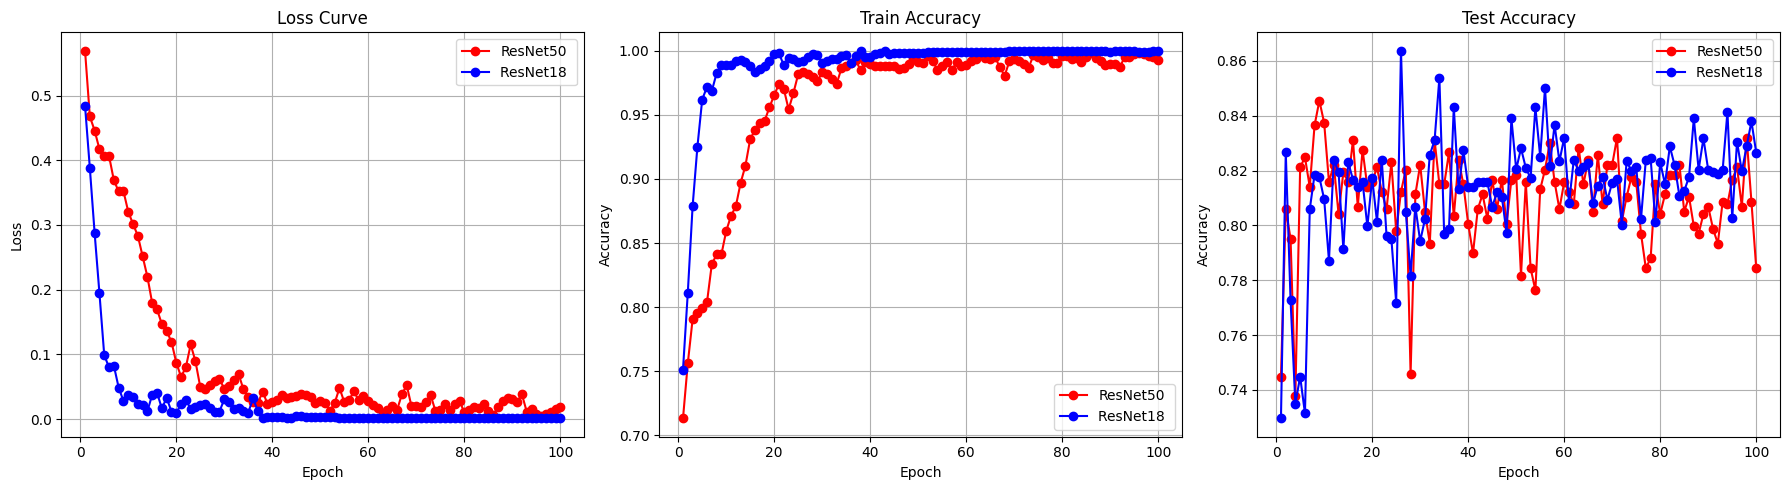

In [123]:
import matplotlib.pyplot as plt
import json

def plot_training_classification(histories, labels, colors=None):
    """
    histories: list of history dicts
    labels: list of labels for each history
    colors: optional list of colors
    """
    if colors is None:
        colors = ["r", "b"] 

    epochs = histories[0]["epoch"]  

    plt.figure(figsize=(18, 5))

    # ---- LOSS ----
    plt.subplot(1, 3, 1)
    for i, history in enumerate(histories):
        plt.plot(epochs, history["train_loss"], label=labels[i], color=colors[i], marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # ---- TRAIN ACC ----
    plt.subplot(1, 3, 2)
    for i, history in enumerate(histories):
        plt.plot(epochs, history["train_acc"], label=labels[i], color=colors[i], marker='o')
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # ---- TEST ACC ----
    plt.subplot(1, 3, 3)
    for i, history in enumerate(histories):
        plt.plot(epochs, history["val_acc"], label=labels[i], color=colors[i], marker='o')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



with open("/kaggle/input/matrics/model_resnet50_history (2).json") as f:
    history2 = json.load(f)

with open("/kaggle/input/matrics/model_resnet18_history (1).json") as f:
    history3 = json.load(f)

histories = [history2, history3]
labels = ["ResNet50", "ResNet18 "]

plot_training_classification(histories, labels)
